# Developing an AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, an image classifier might be included in a smart phone app. To do this, one would use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, the idea is to train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, you can see a few examples below. 

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on the dataset
* Use the trained classifier to predict image content

Although this notebook was implemented to run either on GPU or CPU, it is recommended running on GPU rather than CPU mode.

In [1]:
# Package Imports
#All the necessary packages and modules imported in the first cell of the notebook
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

import torch
import numpy as np
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from collections import OrderedDict
from PIL import Image #Image Module Required for Inference

import json

print("Required Packages Loaded")

Required Packages Loaded


## Load the data

Here you'll use `torchvision` to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). The data should be included alongside this notebook, otherwise you can [download it here](https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz). The dataset is split into three parts, training, validation, and testing. For the training, you'll want to apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. You'll also need to make sure the input data is resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet. For this you don't want any scaling or rotation transformations, but you'll need to resize then crop the images to the appropriate size.

The pre-trained networks you'll use were trained on the ImageNet dataset where each color channel was normalized separately. For all three sets you'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.
 

In [2]:
data_dir = 'flowers'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

In [3]:
# TODO: Define your transforms for the training, validation, and testing sets
#Training data augmentation and Data normalization
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406], 
                                                            [0.229, 0.224, 0.225])])

valid_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], 
                                                           [0.229, 0.224, 0.225])])


test_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], 
                                                           [0.229, 0.224, 0.225])])
# Data loading: Load the datasets with ImageFolder
train_data = datasets.ImageFolder(train_dir, transform=train_transforms)
valid_data = datasets.ImageFolder(valid_dir, transform=valid_transforms)
test_data = datasets.ImageFolder(test_dir, transform=test_transforms)

# Data batching: Using the image datasets and the trainforms, define the dataloaders
trainloader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
validloader = torch.utils.data.DataLoader(valid_data, batch_size=32)
testloader = torch.utils.data.DataLoader(test_data, batch_size=32)
print("Data Images Loaded")

Data Images Loaded


### Label mapping

You'll also need to load in a mapping from category label to category name. You can find this in the file `cat_to_name.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give you a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [4]:
with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. As usual, you should use one of the pretrained models from `torchvision.models` to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. Refer to [the rubric](https://review.udacity.com/#!/rubrics/1663/view) for guidance on successfully completing this section. Things you'll need to do:

* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) (If you need a starting point, the VGG networks work great and are straightforward to use)
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right. Make sure to try different hyperparameters (learning rate, units in the classifier, epochs, etc) to find the best model. Save those hyperparameters to use as default values in the next part of the project.

One last important tip if you're using the workspace to run your code: To avoid having your workspace disconnect during the long-running tasks in this notebook, please read in the earlier page in this lesson called Intro to GPU Workspaces about Keeping Your Session Active. You'll want to include code from the workspace_utils.py module.

In [5]:
# TODO: Build and train your network

In [6]:
#Pretrained Network 
#Loading a pre-trained model
model = models.vgg16(pretrained=True)
#model

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.torch/models/vgg16-397923af.pth
100%|██████████| 553433881/553433881 [00:04<00:00, 117521260.13it/s]


In [7]:
# Freeze parameters so we don't backprop through them
for param in model.parameters():
    param.requires_grad = False

In [8]:
#Feedforward Classifier using ReLU activations and dropout
#Classifier made for a VGG16 model architecture, using three layers and a log softmax output
classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(25088, 4096)),
                          ('relu', nn.ReLU()),
                          ('fc2', nn.Linear(4096, 500)),
                          ('relu1', nn.ReLU()),
                          ('fc3', nn.Linear(500, 102)),
                          ('output', nn.LogSoftmax(dim=1)),
                          ('dropout',nn.Dropout(p=0.3))
                          ]))
    
model.classifier = classifier

In [9]:
classifier

Sequential(
  (fc1): Linear(in_features=25088, out_features=4096, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=4096, out_features=500, bias=True)
  (relu1): ReLU()
  (fc3): Linear(in_features=500, out_features=102, bias=True)
  (output): LogSoftmax()
  (dropout): Dropout(p=0.3)
)

### Setting up the Criterion and Optimizer

In [10]:
#Training the model with a pre-trained network
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)

### Implementing Validation Function and Training the Model

In [11]:
# Implement a function for the validation pass
def validation(model, validloader, criterion):
    #Select GPU if available otherwise run on cpu
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    #Making sure model is in evaluation mode for validation
    model.eval()
    test_loss = 0
    accuracy = 0
    #Iterating through the images in the validation dataset 
    for images, labels in validloader:
        #Moving images and labels to GPU(if available)
        images, labels = images.to(device), labels.to(device)
        #Forward pass 
        output = model.forward(images)
        test_loss += criterion(output, labels).item()

        ps = torch.exp(output)
        equality = (labels.data == ps.max(dim=1)[1])
        accuracy += equality.type(torch.FloatTensor).mean()
    
    return test_loss, accuracy

In [12]:
#Training the model and checking for validation loss and Accuracy
epochs = 3
print_every = 20
steps = 0
print("----------------------------------------------------------")
print("Training the model .... ")

# change to cuda
model.to('cuda')

for e in range(epochs):
    running_loss = 0
    for ii, (inputs, labels) in enumerate(trainloader):
        steps += 1
        
        inputs, labels = inputs.to('cuda'), labels.to('cuda')
        
        optimizer.zero_grad()
        
        # Forward and backward passes
        outputs = model.forward(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        if steps % print_every == 0:
            # Model is in evaluation mode for validation
            model.eval()
            
            # Turning off gradients for validation to save memory and computations
            with torch.no_grad():
                test_loss, accuracy = validation(model, validloader, criterion)
            # Displaying the validation loss and accuracy during training  
            print("Epoch: {}/{}.. ".format(e+1, epochs),
                  "Training Loss: {:.3f}.. ".format(running_loss/print_every),
                  "Validation Loss: {:.3f}.. ".format(test_loss/len(validloader)),
                  "Validation Accuracy: {:.3f}".format(accuracy/len(validloader)))
            
            running_loss = 0
            
            # Making sure training is back on
            model.train()
print("Done Training the Model")
print("----------------------------------------------------------")

----------------------------------------------------------
Training the model .... 
Epoch: 1/3..  Training Loss: 4.801..  Validation Loss: 4.069..  Validation Accuracy: 0.124
Epoch: 1/3..  Training Loss: 3.648..  Validation Loss: 3.104..  Validation Accuracy: 0.300
Epoch: 1/3..  Training Loss: 2.920..  Validation Loss: 2.151..  Validation Accuracy: 0.470
Epoch: 1/3..  Training Loss: 2.256..  Validation Loss: 1.750..  Validation Accuracy: 0.547
Epoch: 1/3..  Training Loss: 1.883..  Validation Loss: 1.492..  Validation Accuracy: 0.603
Epoch: 2/3..  Training Loss: 1.389..  Validation Loss: 1.128..  Validation Accuracy: 0.684
Epoch: 2/3..  Training Loss: 1.552..  Validation Loss: 1.192..  Validation Accuracy: 0.661
Epoch: 2/3..  Training Loss: 1.372..  Validation Loss: 0.941..  Validation Accuracy: 0.735
Epoch: 2/3..  Training Loss: 1.296..  Validation Loss: 0.838..  Validation Accuracy: 0.757
Epoch: 2/3..  Training Loss: 1.286..  Validation Loss: 0.924..  Validation Accuracy: 0.734
Epoch:

## Testing your network

It's good practice to test your trained network on test data, images the network has never seen either in training or validation. This will give you a good estimate for the model's performance on completely new images. Run the test images through the network and measure the accuracy, the same way you did validation. You should be able to reach around 70% accuracy on the test set if the model has been trained well.

In [13]:
# Testing Accuracy: Do validation on the test set
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        
        outputs = model.forward(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the model on the {}'.format(total) + ' test images: %d %%\n' % (100 * correct / total))

Accuracy of the model on the 819 test images: 77 %



## Save the checkpoint

Now that your network is trained, save the model so you can load it later for making predictions. You probably want to save other things such as the mapping of classes to indices which you get from one of the image datasets: `image_datasets['train'].class_to_idx`. You can attach this to the model as an attribute which makes inference easier later on.

```model.class_to_idx = image_datasets['train'].class_to_idx```

Remember that you'll want to completely rebuild the model later so you can use it for inference. Make sure to include any information you need in the checkpoint. If you want to load the model and keep training, you'll want to save the number of epochs as well as the optimizer state, `optimizer.state_dict`. You'll likely want to use this trained model in the next part of the project, so best to save it now.

In [14]:
# Saving the model: Save the checkpoint 
model.class_to_idx = train_data.class_to_idx
checkpoint = {'classifier': model.classifier,
    'optimizer': optimizer,
    'arch': "vgg16",#choose model architecture 
    'state_dict': model.state_dict(),
    'epochs':epochs,
    'optimizer_state': optimizer.state_dict(),
    'class_to_idx': model.class_to_idx
}
torch.save(checkpoint,'checkpoint.pth')

print("checkpoint saved")

checkpoint saved


## Loading the checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way you can come back to this project and keep working on it without having to retrain the network.

In [15]:
# Loading checkpoints: Write a function that loads a checkpoint and rebuilds the model
def load_checkpoint(filepath):
    checkpoint= torch.load(filepath, map_location=lambda storage, loc: storage)
    
    model = getattr(models, checkpoint['arch'])(pretrained=True)
    model.class_to_idx = checkpoint['class_to_idx']
    model.classifier = checkpoint['classifier']
    model.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state'])
    epoch = checkpoint['epochs']
    #Check if GPU is available, otherwise run on cpu
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)
    #Run on evaluation mode for inference
    model.eval()
    
    return model

print("checkpoint loaded")

checkpoint loaded


In [16]:
#loading the model and checking it
model = load_checkpoint('checkpoint.pth')
model.classifier

Sequential(
  (fc1): Linear(in_features=25088, out_features=4096, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=4096, out_features=500, bias=True)
  (relu1): ReLU()
  (fc3): Linear(in_features=500, out_features=102, bias=True)
  (output): LogSoftmax()
  (dropout): Dropout(p=0.3)
)

# Inference for classification

Now you'll write a function to use a trained network for inference. That is, you'll pass an image into the network and predict the class of the flower in the image. Write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. It should look like 

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

First you'll need to handle processing the input image such that it can be used in your network. 

## Image Preprocessing

You'll want to use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training. 

First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then you'll need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. You'll need to convert the values. It's easiest with a Numpy array, which you can get from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. You'll want to subtract the means from each color channel, then divide by the standard deviation. 

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. You can reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

In [17]:
#Image Processing
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    
    # TODO: Process a PIL image for use in a PyTorch model
    #Formatting the images as used for training 
    preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor()])
    IM = Image.open(image)
    pil_image = preprocess(IM).float() 
    np_image = np.array(pil_image) #converting color channels to 0-1 floats 
        
    #Normalization 
    means = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    #Reordering dimensions using ndarray.transpose
    norm_image = (np.transpose(np_image, (1, 2, 0)) - means)/std    
    proc_image = np.transpose(norm_image, (2, 0, 1))
    
    ### OBS: function returns an np.array ########## 
    return proc_image

To check your work, the function below converts a PyTorch tensor and displays it in the notebook. If your `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

In [18]:
def imshow(image, ax=None, title=None):
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

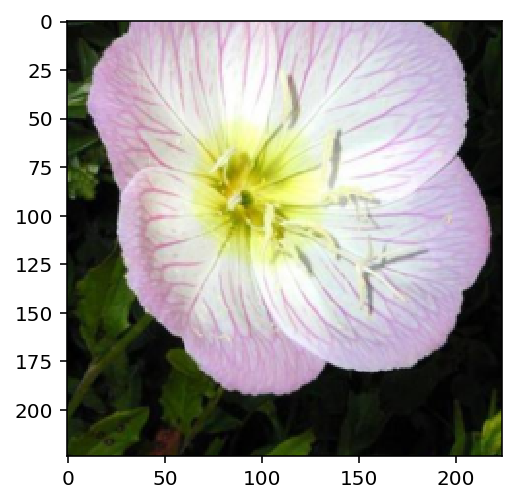

In [19]:
#Checking preprocessing 
imshow(process_image('flowers/test/1/image_06743.jpg'))

## Class Prediction

Once you can get images in the correct format, it's time to write a function for making predictions with your model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. You'll want to calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. You need to convert from these indices to the actual class labels using `class_to_idx` which hopefully you added to the model or from an `ImageFolder` you used to load the data ([see here](#Save-the-checkpoint)). Make sure to invert the dictionary so you get a mapping from index to class as well.

Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

In [20]:
#Class Prediction: Function takes the path to an image and a checkpoint, then returns the 
#top k (default = 5) most probable classes for that image 
def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    
    # TODO: Implement the code to predict the class from an image file
    #Calling the preprocessing function      
    proc_image = process_image(image_path)
    # process_image function returns a np.array(), conversion needed before using it on the model
    t_proc_image = torch.from_numpy(proc_image)
    torch_image = t_proc_image.unsqueeze_(0)
    torch_image = torch_image.type(torch.FloatTensor)
    torch_image = torch_image.to(device) 
    output = model(torch_image)
    ######### Correction for negative probabilities #################################
    funct_ps = torch.exp(output)
    #getting the topk largest values from the tensor (default = 5)
    probs, top_classes = torch.topk(funct_ps, topk) 
   
    ###Changing dtypes and inverting the dictionary to get a mapping from index to class #####
    probs = [float(prob) for prob in probs[0]] 
    
    inv_map = {v: k for k, v in model.class_to_idx.items()}
    
    top_classes = [inv_map[int(index)] for index in top_classes[0]]
        
    return probs, top_classes

## Sanity Checking

Now that you can use a trained model for predictions, check to make sure it makes sense. Even if the testing accuracy is high, it's always good to check that there aren't obvious bugs. Use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image. It should look like this:

<img src='assets/inference_example.png' width=300px>

You can convert from the class integer encoding to actual flower names with the `cat_to_name.json` file (should have been loaded earlier in the notebook). To show a PyTorch tensor as an image, use the `imshow` function defined above.

# TODO: Display an image along with the top 5 classes
plt.figure(figsize=(4,4))
    
path = ('flowers/test/1/image_06743.jpg') 
    
probs, classes = predict(path, model)

print("probabilities: ", probs) 
print("classes: ", classes)

proc_image = process_image(path) 
max_index = classes[0]
    
axs = imshow(proc_image, ax = plt)
axs.axis('off')

axs.title(cat_to_name[str(max_index)])

axs.show()
plt.figure(figsize=(4,4))
names = [cat_to_name[str(index)] for index in classes]
y_pos = np.arange(len(names))
probabilities = np.array(probs)
plt.barh(y_pos, probabilities, align='center',
        color='blue')
plt.yticks(y_pos, names)
plt.gca().invert_yaxis()

The most probable classification for this flower is: pink primrose

With an associated probability of: 0.892


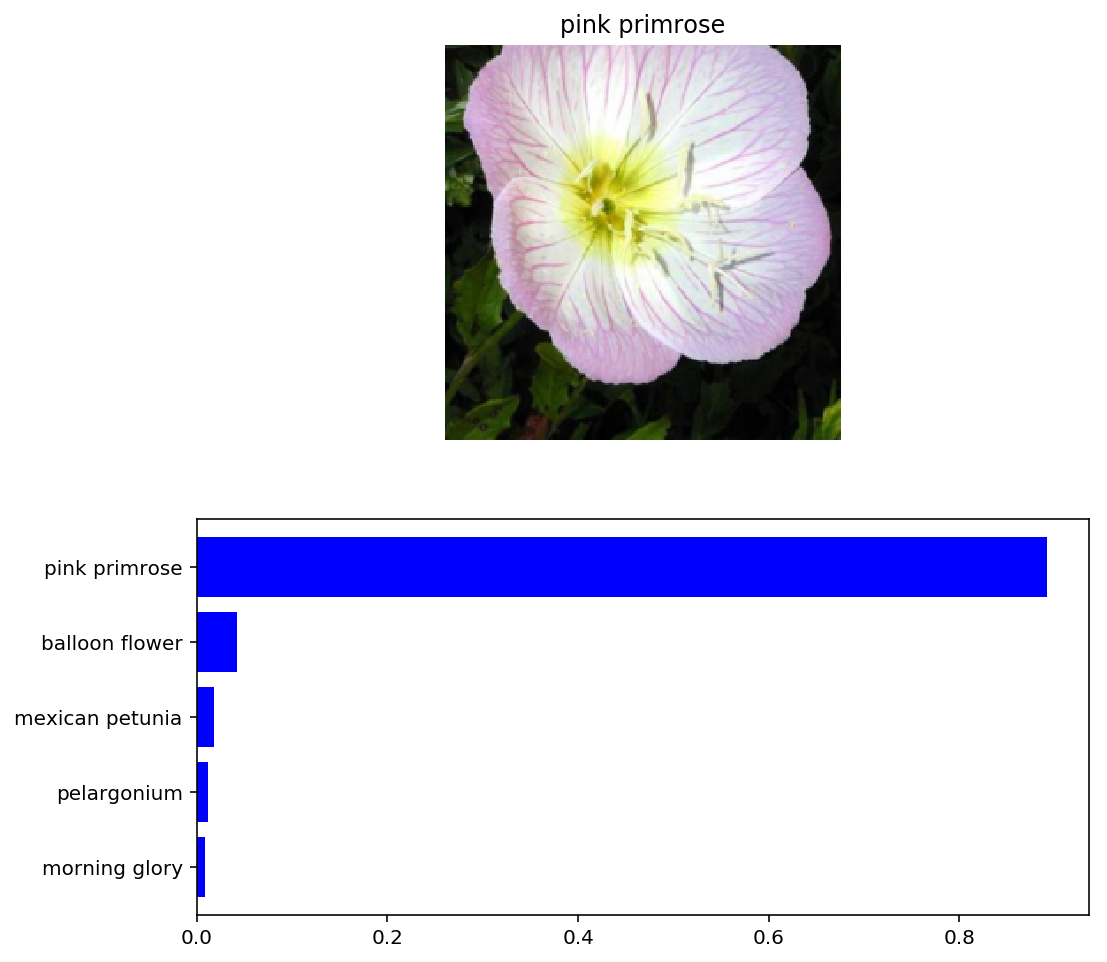

In [21]:
################## Sanity Checking ######################
##### 
path = ('flowers/test/1/image_06743.jpg')

probs, classes = predict(path, model)
names = [cat_to_name[str(index)] for index in classes]
print("The most probable classification for this flower is: {}\n".format(names[0]))
print("With an associated probability of: {:.3f}".format(probs[0]))

proc_image = process_image(path)
max_index = classes[0]

fig = plt.figure(figsize=(8,8))
##### Showing flower image ###########
fig.add_subplot(211)
imgplot = proc_image
imgplot = imgplot.transpose((1, 2, 0))

mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
imgplot = std * imgplot + mean
    
# Image needs to be clipped between 0 and 1 or it looks like noise when displayed
imgplot = np.clip(imgplot, 0, 1)
plt.title(cat_to_name[str(max_index)])
plt.axis('off')
plt.imshow(imgplot)

### showing the graph #########
fig.add_subplot(212)
#names = [cat_to_name[str(index)] for index in classes]
y_pos = np.arange(len(names))
probabilities = np.array(probs)
plt.barh(y_pos, probabilities, align='center',
        color='blue')
plt.yticks(y_pos, names)
plt.gca().invert_yaxis()
plt.show()

# References:

**List of main references used for code development and troubleshooting**

* [Udacity AI_ND_Lesson 4: Deep Learning with PyTorch](https://classroom.udacity.com/nanodegrees/nd089/parts/4f56c240-e23f-49ae-9b84-b84c980fad9c/modules/47a93218-8271-457b-aca6-e2cdca10131b/lessons/e1eeafe1-2ba0-4f3d-97a0-82cbd844fdfc/concepts/1d0be3d3-71ca-4d44-a080-183771ab3957)
* [Create Image Classifier Project Rubrics](https://review.udacity.com/#!/rubrics/1663/view)
* [Udacity Knowledge](https://knowledge.udacity.com/?nanodegree=af049018-594c-11e8-aa9b-67ca2fa14b49&page=1&project=a08438cc-594c-11e8-9b2c-4b5f0aa8d706&query=predict&sort=RELEVANCE)
* [Saving and Loading Models](https://pytorch.org/tutorials/beginner/saving_loading_models.html#saving-loading-model-for-inference)
* [Training a Classifier](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#sphx-glr-beginner-blitz-cifar10-tutorial-py)
* [Image Module/ PIL](https://pillow.readthedocs.io/en/latest/reference/Image.html)
* [Converting numpy arrays to tensor on GPU](https://discuss.pytorch.org/t/converting-numpy-array-to-tensor-on-gpu/19423)
* [Solving batch dimensions error](https://discuss.pytorch.org/t/expected-stride-to-be-a-single-integer-value-or-a-list/17612)
* [Solving SyntaxError: unexpected EOF while parsing](https://stackoverflow.com/questions/43189302/syntaxerror-unexpected-eof-while-parsing)
* [Converting data into tensor](https://stackoverflow.com/questions/47272971/pytorch-how-to-convert-data-into-tensor)
* [IMAGENET](http://www.image-net.org/)
* [RuntimeError: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same](https://discuss.pytorch.org/t/runtimeerror-input-type-torch-cuda-floattensor-and-weight-type-torch-floattensor-should-be-the-same/21782)
* [Image and Graph Plotting](https://stackoverflow.com/questions/42730650/how-do-i-plot-an-image-and-a-graph-side-by-side)
* [Matplotlib Tutorial](https://www.python-course.eu/matplotlib_multiple_figures.php)
* [Matplotlib Image Tutorial](https://matplotlib.org/users/image_tutorial.html)